In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


In [2]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
import datetime


In [3]:
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)


In [4]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [5]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    #x = layers.GlobalAveragePooling2D(data_format="channels_first")(x)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)


In [6]:
use_original = False
if use_original:
    names = ['year', 'month', 'day', 'dec_year', 'sn_value' , 'sn_error', 'obs_num', 'extra']
    target_col = 'sn_value'
    periods_per_day = 6

    fn = "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv"
    df = pd.read_csv(fn,
        sep=';',header=None,names=names,
        na_values=['-1'], index_col=False)

else:
    names = ['date', 'year','close', 'target',]
    target_col = 'target'
    perdiods_per_day = 10
    ticker = 'fvty'

    #fn = "c://data//transformer_data_heaton.csv"
    #fn = "c://data//transformer_data_" + ticker + ".csv"
    fn = "c:/dev/github/UChicago/Winter2023/UChicago-Winter2023/transformers/transformer_data_" + ticker + ".csv"
    df = pd.read_csv(fn, sep=',', na_values=['-1'], index_col=False)



# Find the last zero and move one beyond
#start_id = max(df[df['obs_num'] == 0].index.tolist())+1  
#print(start_id)
#df = df[start_id:] # Trim the rows that have missing observatio

#df['sn_value'] = df['sn_value'].astype(float)

#wrap a loop starting here and grab train and test data from the original df..

windowsize = 7000
stepsize   = 50
periodsperday = 6
perdiods_per_day = periodsperday
input_fields = [target_col,'obs_num','sn_error']
target_field = [target_col]
input_fields = target_field


In [ ]:
SEQUENCE_SIZE   = 10
pnls    = []
row,col = df.shape
start = datetime.datetime.now()

for x in range(windowsize,row-stepsize,stepsize):
    print("Iteration x = ",x," to row-stepsize ",row-stepsize)
    df_train = df.iloc[x-windowsize:x,:]
    df_test  = df.iloc[x:x+stepsize]
    df = df.loc[:,input_fields]
    spots_train = df_train[target_col].tolist()
    spots_test = df_test[target_col].tolist()
    #spots_train = df.apply(lambda x: x.tolist(), axis=1).tolist()
    #spots_test = df.apply(lambda x: x.tolist(), axis=1).tolist()

#    print("Training set has {} observations.".format(len(spots_train)))
#    print("Test set has {} observations.".format(len(spots_test)))
    x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
    x_test,y_test   = to_sequences(SEQUENCE_SIZE,spots_test)

#    print("Shape of training set: {}".format(x_train.shape))
#    print("Shape of test set: {}".format(x_test.shape))

    input_shape = x_train.shape[1:]
#    print(input_shape)
    
    model = build_model(
        
        input_shape,
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )

    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4)
    )

    model.summary()

    callbacks = [keras.callbacks.EarlyStopping(patience=10, \
        restore_best_weights=True)]

    model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=64,
        callbacks=callbacks,
    )
    finish = datetime.datetime.now()
    
    model.evaluate(x_test, y_test, verbose=1)



    pred = model.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Score (RMSE): {}".format(score)) 

    total   = 0
    counter = 0

    for x in range(len(pred)):
        if pred[x] > 0.0:
            total = y_test[x]
        elif pred[x] < 0.0:
            total = -1*y_test[x]
        pnls.append([x,pred[x],y_test[x],total])

    print("time to execute = ",finish-start)

dfpnl = pd.DataFrame(data = pnls, columns=['cumpnl'])
dfpnl['pnl'] = dfpnl['cumpnl'] - dfpnl['cumpnl'].shift(1)

dfpnl['cummax'] = dfpnl['cumpnl'].cummax()
ret = dfpnl['pnl'].mean()*252
vol = dfpnl['pnl'].std()*pow(252,0.5)
dfpnl['dd'] = dfpnl['cummax'] - df['cumpnl']
mdd = dfpnl['dd'].max()
print("Return = ",ret)
print("Vol    = ",vol)
info =0
if(vol>0):
    info = ret/vol
print("Info  = ",info)
calmar=0
if (mdd>0):
    calmar = ret/mdd
print("MDD  = ",mdd)
print("Calmar = ",calmar)
df['cumpnl'].plot()
df['cummax'].plot()

Iteration x =  7000  to row-stepsize  7797
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 10, 1)       2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 10, 1)       7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                   

 mbda)                                                            'tf.__operators__.add_5[0][0]'] 
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 10, 1)       2           ['tf.__operators__.add_6[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv1d_6 (Conv1D)              (None, 10, 4)        8           ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_7 (Dropout)            (None, 10, 4)        0           ['conv1d_6[0][0]']               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 10, 1)        5           ['dropout_7[0][0]']              
          

 tf.__operators__.add_8 (TFOpLa  (None, 10, 1)       0           ['dropout_9[0][0]',              
 mbda)                                                            'input_2[0][0]']                
                                                                                                  
 layer_normalization_9 (LayerNo  (None, 10, 1)       2           ['tf.__operators__.add_8[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv1d_8 (Conv1D)              (None, 10, 4)        8           ['layer_normalization_9[0][0]']  
                                                                                                  
 dropout_10 (Dropout)           (None, 10, 4)        0           ['conv1d_8[0][0]']               
                                                                                                  
 conv1d_9 

                                                                                                  
 global_average_pooling1d_1 (Gl  (None, 10)          0           ['tf.__operators__.add_15[0][0]']
 obalAveragePooling1D)                                                                            
                                                                                                  
 dense_2 (Dense)                (None, 128)          1408        ['global_average_pooling1d_1[0][0
                                                                 ]']                              
                                                                                                  
 dropout_17 (Dropout)           (None, 128)          0           ['dense_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 1)            129         ['dropout_17[0][0]']             
          

 conv1d_16 (Conv1D)             (None, 10, 4)        8           ['layer_normalization_17[0][0]'] 
                                                                                                  
 dropout_19 (Dropout)           (None, 10, 4)        0           ['conv1d_16[0][0]']              
                                                                                                  
 conv1d_17 (Conv1D)             (None, 10, 1)        5           ['dropout_19[0][0]']             
                                                                                                  
 tf.__operators__.add_17 (TFOpL  (None, 10, 1)       0           ['conv1d_17[0][0]',              
 ambda)                                                           'tf.__operators__.add_16[0][0]']
                                                                                                  
 layer_normalization_18 (LayerN  (None, 10, 1)       2           ['tf.__operators__.add_17[0][0]']
 ormalizat

                                                                                                  
 dropout_26 (Dropout)           (None, 128)          0           ['dense_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 1)            129         ['dropout_26[0][0]']             
                                                                                                  
Total params: 30,281
Trainable params: 30,281
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/200
88/88 [==============================] - 16s 137ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 2/200
88/88 [==============================] - 11s 130ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 3/200
88/88 [==============================] - 11s 129ms/step - loss: 9.7579e-04 - val_loss: 0.0013
Epoch 4/200
88/88 [=======

 ambda)                                                           'tf.__operators__.add_26[0][0]']
                                                                                                  
 layer_normalization_28 (LayerN  (None, 10, 1)       2           ['tf.__operators__.add_27[0][0]']
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_14 (Multi  (None, 10, 1)       7169        ['layer_normalization_28[0][0]', 
 HeadAttention)                                                   'layer_normalization_28[0][0]'] 
                                                                                                  
 dropout_31 (Dropout)           (None, 10, 1)        0           ['multi_head_attention_14[0][0]']
                                                                                                  
 tf.__oper

88/88 [==============================] - 11s 130ms/step - loss: 8.6938e-04 - val_loss: 0.0013
Epoch 22/200
88/88 [==============================] - 11s 128ms/step - loss: 8.7194e-04 - val_loss: 0.0013
Epoch 23/200
88/88 [==============================] - 11s 130ms/step - loss: 8.8040e-04 - val_loss: 0.0013
Epoch 24/200
88/88 [==============================] - 12s 131ms/step - loss: 8.7445e-04 - val_loss: 0.0013
Epoch 25/200
2/2 [==============================] - 0s 10ms/step
Score (RMSE): 0.03245164929157824
time to execute =  0:25:15.517621
Iteration x =  7200  to row-stepsize  7797
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                               

 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_19 (Multi  (None, 10, 1)       7169        ['layer_normalization_38[0][0]', 
 HeadAttention)                                                   'layer_normalization_38[0][0]'] 
                                                                                                  
 dropout_42 (Dropout)           (None, 10, 1)        0           ['multi_head_attention_19[0][0]']
                                                                                                  
 tf.__operators__.add_38 (TFOpL  (None, 10, 1)       0           ['dropout_42[0][0]',             
 ambda)                                                           'tf.__operators__.add_37[0][0]']
                                                                                                  
 layer_nor

In [116]:
print(len(pnls))
print(pnls[10])


640
[10, array([-0.0005572], dtype=float32), 0.0296875, -0.0296875]


In [117]:
print("length of PNL = ",len(pnls))
x = len(pnls)
periods = x*stepsize
print("periods = ",periods)
days = periods/periodsperday
print("days = ",days)
daysperstep = stepsize/periodsperday
print("days in each step = ",daysperstep)

length of PNL =  640
periods =  32000
days =  5333.333333333333
days in each step =  8.333333333333334


   index      pred    actual       pnl
0      0  0.002288 -0.005468 -0.005468
1      1 -0.000890  0.023436 -0.023436
2      2 -0.002429 -0.000781  0.000781
3      3 -0.000301 -0.006250  0.006250
4      4  0.000369 -0.050000 -0.050000
     index      pred    actual       pnl  switch    cumpnl
635     35 -0.003892 -0.011719  0.011719      -1  0.893726
636     36  0.001324 -0.002344 -0.002344       1  0.891382
637     37  0.002768 -0.018749 -0.018749       1  0.872633
638     38  0.002367 -0.011719 -0.011719       1  0.860914
639     39 -0.000583  0.002343 -0.002343      -1  0.858571
Return =  0.17886901041666664
Vol    =  0.38644137672571766
Info  =  0.4628619531692164
MDD  =  0.94765975
Calmar =  0.188748134989026


<AxesSubplot:>

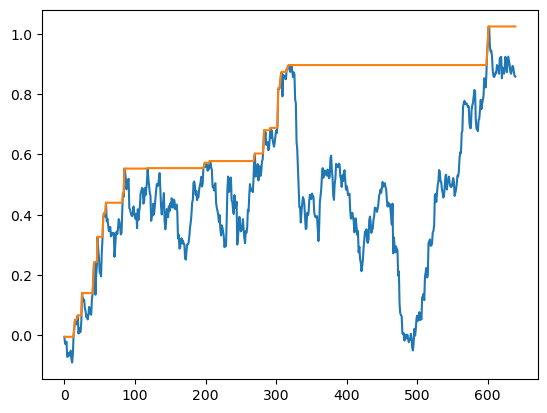

In [118]:
cols = ['index','pred','actual','pnl']
dfpnl = pd.DataFrame(data = pnls, columns=cols)
dfpnl['pred'] = dfpnl['pred'].apply(lambda x: x[0])
print(dfpnl.head())

dfpnl['switch'] = dfpnl['pred'].apply(lambda x  : 1 if x>0 else -1 )
dfpnl['pnl'] = dfpnl['switch'] * dfpnl['actual']
#dfpnl = dfpnl.assign(pnl = lambda r: r['actual'] if r['pred'] > 0   else -1* r['actual'])


for index,row in dfpnl.iterrows():
    row['pred2'] = row['pred']
    wt = 1.0
    if (row['pred']<0):
        wt = -1.0
    dfpnl.loc[index,'pnl'] = wt * dfpnl.loc[index,'actual']

dfpnl['cumpnl'] = dfpnl['pnl'].cumsum()
print(dfpnl.tail())
dfpnl['cummax'] = dfpnl['cumpnl'].cummax()
ret = dfpnl['pnl'].mean()*(252/1.89)
vol = dfpnl['pnl'].std()*pow(252/1.89,0.5)
dfpnl['dd'] = dfpnl['cummax'] - dfpnl['cumpnl']
mdd = dfpnl['dd'].max()
print("Return = ",ret)
print("Vol    = ",vol)
info =0
if(vol>0):
    info = ret/vol
print("Info  = ",info)
calmar=0
if (mdd>0):
    calmar = ret/mdd
print("MDD  = ",mdd)
print("Calmar = ",calmar)
dfpnl['cumpnl'].plot()
dfpnl['cummax'].plot()

In [121]:
dfpnl.to_csv("c://data//transformer_output_" + ticker + ".csv")





